## Train and Export Pipeline

Register custom COCO datasets, setup model from c4_faster_rcnn_fbnetv3a_C4.yaml, run training and export for mobile.

In [1]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("c4_train", {}, "datasets/c4/labels.json", "datasets/c4/clean")
register_coco_instances("c4_val", {}, "datasets/c4/labels.json", "datasets/c4/clean")

/home/tho121/c4project_final/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
register_coco_instances("c4_train_set2", {}, "datasets/set2/labels_set2.json", "datasets/set2/clean")
register_coco_instances("c4_val_set2", {}, "datasets/set2/labels_set2.json", "datasets/set2/clean")

In [3]:
import os
from d2go.runner import GeneralizedRCNNRunner
from d2go.model_zoo import model_zoo

def prepare_for_launch():
    runner = GeneralizedRCNNRunner()
    cfg = runner.get_default_cfg()
    cfg.merge_from_file("c4_faster_rcnn_fbnetv3a_C4.yaml")
    cfg.MODEL_EMA.ENABLED = False
    cfg.DATASETS.TRAIN = ("c4_train","c4_train_set2")
    cfg.DATASETS.TEST = ("c4_val","c4_val_set2")
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = None #model_zoo.get_checkpoint_url("faster_rcnn_fbnetv3a_C4.yaml")  # Let training initialize from model zoo
    cfg.MODEL.DEVICE = "cpu" if ('CI' in os.environ) else "cuda"
    cfg.SOLVER.IMS_PER_BATCH = 8
    cfg.SOLVER.BASE_LR = 0.05  # pick a good LR
    cfg.SOLVER.MAX_ITER = 25000    # 600 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
    cfg.SOLVER.STEPS = []        # do not decay learning rate
    cfg.SOLVER.OPTIMIZER = 'adamw_mt'
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
    # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    return cfg, runner

In [4]:
import torch
if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [5]:
cfg, runner = prepare_for_launch()
model = runner.build_model(cfg)
#model.load_state_dict(torch.load("output_2/model_final.pth")['model'])

INFO:d2go.modeling.backbone.fbnet_v2:Using un-unified arch_def for ARCH "FBNetV3_A_dsmask" (without scaling):
trunk
- [('conv_k3', 16, 2, 1), ('ir_k3', 16, 1, 1, {'expansion': 1}, {'less_se_channels': False})]
- [('ir_k5', 32, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k5', 32, 1, 1, {'expansion': 2}, {'less_se_channels': False})]
- [('ir_k5', 40, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k3', 40, 1, 3, {'expansion': 3}, {'less_se_channels': False})]
- [('ir_k5', 72, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k3', 72, 1, 3, {'expansion': 3}, {'less_se_channels': False}), ('ir_k5', 112, 1, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k5', 112, 1, 3, {'expansion': 4}, {'less_se_channels': False})]
rpn
- [('ir_k5', 112, 1, 3, {'expansion': 4}, {'less_se_channels': False})]
bbox
- [('ir_k3', 128, 2, 1, {'expansion': 4}), ('ir_k3', 128, 1, 2, {'expansion': 6}), ('ir_k3', 160, 1, 1, {'expansion': 6})]
mask
- [('ir_k3', 128, 2, 1, {'

In [6]:
runner.do_train(cfg, model, resume=False)

INFO:d2go.optimizer.build:Using optimizer:
NewCls (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: True
    lr: 0.05
    maximize: False
    weight_decay: 0.0001

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: True
    lr: 0.05
    maximize: False
    weight_decay: 0.0
)
INFO:d2go.optimizer.build:optimizer parameter groups:
Param group 0: {amsgrad: False, betas: (0.9, 0.999), capturable: False, eps: 1e-08, foreach: True, lr: 0.05, maximize: False, params: 75, weight_decay: 0.0001}
Param group 1: {amsgrad: False, betas: (0.9, 0.999), capturable: False, eps: 1e-08, foreach: True, lr: 0.05, maximize: False, params: 88, weight_decay: 0.0}

INFO:fvcore.common.checkpoint:No checkpoint found. Initializing model from scratch
INFO:d2go.data.build:Building D2Go's train loader ...
INFO:d2go.data.build:Using dataset mapper:
D2GoDatasetMapper:
  is_train: True
  image_load

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.727
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.946
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.737
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.270
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.710
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.772
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.707
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.

INFO:detectron2.evaluation.evaluator:Inference done 11/30. Dataloading: 0.0358 s/iter. Inference: 0.0383 s/iter. Eval: 0.4055 s/iter. Total: 0.4797 s/iter. ETA=0:00:09
INFO:detectron2.evaluation.evaluator:Total inference time: 0:00:05.654590 (0.226184 s / iter per device, on 1 devices)
INFO:detectron2.evaluation.evaluator:Total inference pure compute time: 0:00:00 (0.032064 s / iter per device, on 1 devices)
INFO:detectron2.evaluation.coco_evaluation:Preparing results for COCO format ...
INFO:detectron2.evaluation.coco_evaluation:Saving results to ./output/inference/default/4999/c4_val_set2/coco_instances_results.json
INFO:detectron2.evaluation.coco_evaluation:Evaluating predictions with unofficial COCO API...
INFO:detectron2.evaluation.fast_eval_api:Evaluate annotation type *bbox*
INFO:detectron2.evaluation.fast_eval_api:COCOeval_opt.evaluate() finished in 0.03 seconds.
INFO:detectron2.evaluation.fast_eval_api:Accumulating evaluation results...
INFO:detectron2.evaluation.fast_eval_api

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.736
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.945
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.937
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.733
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.223
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.632
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.770
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.776
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.799
 Average Recall     (AR) @[ IoU=0.50:0.

INFO:detectron2.utils.events: eta: 2:01:16  iter: 5019  total_loss: 0.544  loss_cls: 0.09479  loss_box_reg: 0.2469  loss_rpn_cls: 0.01493  loss_rpn_loc: 0.1826  time: 0.3727  data_time: 0.0753  lr: 0.04519  max_mem: 1589M
INFO:detectron2.utils.events: eta: 2:01:11  iter: 5039  total_loss: 0.5287  loss_cls: 0.09128  loss_box_reg: 0.2366  loss_rpn_cls: 0.01322  loss_rpn_loc: 0.1776  time: 0.3727  data_time: 0.0732  lr: 0.045153  max_mem: 1589M
INFO:detectron2.utils.events: eta: 2:01:05  iter: 5059  total_loss: 0.4903  loss_cls: 0.07573  loss_box_reg: 0.2105  loss_rpn_cls: 0.0152  loss_rpn_loc: 0.1831  time: 0.3727  data_time: 0.0754  lr: 0.045116  max_mem: 1589M
INFO:detectron2.utils.events: eta: 2:00:59  iter: 5079  total_loss: 0.515  loss_cls: 0.08756  loss_box_reg: 0.2267  loss_rpn_cls: 0.01714  loss_rpn_loc: 0.1761  time: 0.3727  data_time: 0.0740  lr: 0.045079  max_mem: 1589M
INFO:detectron2.utils.events: eta: 2:00:48  iter: 5099  total_loss: 0.5466  loss_cls: 0.08797  loss_box_reg:

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.828
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.993
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.790
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.832
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.854
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.859
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.829
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.863
 Average Recall     (AR) @[ IoU=0.50:0.

INFO:detectron2.evaluation.evaluator:Inference done 11/30. Dataloading: 0.0395 s/iter. Inference: 0.0337 s/iter. Eval: 0.4270 s/iter. Total: 0.5002 s/iter. ETA=0:00:09
INFO:detectron2.evaluation.evaluator:Total inference time: 0:00:06.040229 (0.241609 s / iter per device, on 1 devices)
INFO:detectron2.evaluation.evaluator:Total inference pure compute time: 0:00:00 (0.031981 s / iter per device, on 1 devices)
INFO:detectron2.evaluation.coco_evaluation:Preparing results for COCO format ...
INFO:detectron2.evaluation.coco_evaluation:Saving results to ./output/inference/default/9999/c4_val_set2/coco_instances_results.json
INFO:detectron2.evaluation.coco_evaluation:Evaluating predictions with unofficial COCO API...
INFO:detectron2.evaluation.fast_eval_api:Evaluate annotation type *bbox*
INFO:detectron2.evaluation.fast_eval_api:COCOeval_opt.evaluate() finished in 0.02 seconds.
INFO:detectron2.evaluation.fast_eval_api:Accumulating evaluation results...
INFO:detectron2.evaluation.fast_eval_api

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.863
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.843
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.871
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.873
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.730
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.886
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.873
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.889
 Average Recall     (AR) @[ IoU=0.50:0.

INFO:detectron2.utils.events: eta: 1:28:25  iter: 10019  total_loss: 0.3486  loss_cls: 0.05718  loss_box_reg: 0.164  loss_rpn_cls: 0.006168  loss_rpn_loc: 0.1116  time: 0.3708  data_time: 0.0731  lr: 0.032669  max_mem: 1589M
INFO:detectron2.utils.events: eta: 1:28:18  iter: 10039  total_loss: 0.3463  loss_cls: 0.0613  loss_box_reg: 0.1608  loss_rpn_cls: 0.007516  loss_rpn_loc: 0.1179  time: 0.3708  data_time: 0.0771  lr: 0.032609  max_mem: 1589M
INFO:detectron2.utils.events: eta: 1:28:13  iter: 10059  total_loss: 0.344  loss_cls: 0.05559  loss_box_reg: 0.1554  loss_rpn_cls: 0.006101  loss_rpn_loc: 0.1274  time: 0.3708  data_time: 0.0758  lr: 0.032549  max_mem: 1589M
INFO:detectron2.utils.events: eta: 1:28:15  iter: 10079  total_loss: 0.3654  loss_cls: 0.06444  loss_box_reg: 0.1631  loss_rpn_cls: 0.005542  loss_rpn_loc: 0.1269  time: 0.3708  data_time: 0.0746  lr: 0.032489  max_mem: 1589M
INFO:detectron2.utils.events: eta: 1:28:14  iter: 10099  total_loss: 0.3766  loss_cls: 0.06454  los

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.913
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.873
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.908
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.946
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.858
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.938
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.901
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.932
 Average Recall     (AR) @[ IoU=0.50:0.

INFO:detectron2.evaluation.evaluator:Inference done 11/30. Dataloading: 0.0375 s/iter. Inference: 0.0344 s/iter. Eval: 0.3823 s/iter. Total: 0.4542 s/iter. ETA=0:00:08
INFO:detectron2.evaluation.evaluator:Total inference time: 0:00:05.397229 (0.215889 s / iter per device, on 1 devices)
INFO:detectron2.evaluation.evaluator:Total inference pure compute time: 0:00:00 (0.028063 s / iter per device, on 1 devices)
INFO:detectron2.evaluation.coco_evaluation:Preparing results for COCO format ...
INFO:detectron2.evaluation.coco_evaluation:Saving results to ./output/inference/default/14999/c4_val_set2/coco_instances_results.json
INFO:detectron2.evaluation.coco_evaluation:Evaluating predictions with unofficial COCO API...
INFO:detectron2.evaluation.fast_eval_api:Evaluate annotation type *bbox*
INFO:detectron2.evaluation.fast_eval_api:COCOeval_opt.evaluate() finished in 0.02 seconds.
INFO:detectron2.evaluation.fast_eval_api:Accumulating evaluation results...
INFO:detectron2.evaluation.fast_eval_ap

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.935
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.998
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.998
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.909
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.922
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.966
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.793
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.956
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.934
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.956
 Average Recall     (AR) @[ IoU=0.50:0.

INFO:detectron2.utils.events: eta: 0:59:53  iter: 15019  total_loss: 0.2  loss_cls: 0.03688  loss_box_reg: 0.1012  loss_rpn_cls: 0.002047  loss_rpn_loc: 0.05821  time: 0.3711  data_time: 0.0775  lr: 0.017218  max_mem: 1589M
INFO:detectron2.utils.events: eta: 0:59:45  iter: 15039  total_loss: 0.2035  loss_cls: 0.03752  loss_box_reg: 0.09931  loss_rpn_cls: 0.002868  loss_rpn_loc: 0.06129  time: 0.3711  data_time: 0.0751  lr: 0.017158  max_mem: 1589M
INFO:detectron2.utils.events: eta: 0:59:31  iter: 15059  total_loss: 0.2014  loss_cls: 0.03082  loss_box_reg: 0.1003  loss_rpn_cls: 0.002181  loss_rpn_loc: 0.06228  time: 0.3711  data_time: 0.0750  lr: 0.017099  max_mem: 1589M
INFO:detectron2.utils.events: eta: 0:59:15  iter: 15079  total_loss: 0.1989  loss_cls: 0.03119  loss_box_reg: 0.1019  loss_rpn_cls: 0.00188  loss_rpn_loc: 0.06172  time: 0.3711  data_time: 0.0765  lr: 0.017039  max_mem: 1589M
INFO:detectron2.utils.events: eta: 0:59:03  iter: 15099  total_loss: 0.1903  loss_cls: 0.03462 

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.966
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.949
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.993
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.894
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.978
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.964
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.968
 Average Recall     (AR) @[ IoU=0.50:0.

INFO:detectron2.evaluation.evaluator:Inference done 11/30. Dataloading: 0.0368 s/iter. Inference: 0.0343 s/iter. Eval: 0.4159 s/iter. Total: 0.4870 s/iter. ETA=0:00:09
INFO:detectron2.evaluation.evaluator:Total inference time: 0:00:05.967914 (0.238717 s / iter per device, on 1 devices)
INFO:detectron2.evaluation.evaluator:Total inference pure compute time: 0:00:00 (0.034127 s / iter per device, on 1 devices)
INFO:detectron2.evaluation.coco_evaluation:Preparing results for COCO format ...
INFO:detectron2.evaluation.coco_evaluation:Saving results to ./output/inference/default/19999/c4_val_set2/coco_instances_results.json
INFO:detectron2.evaluation.coco_evaluation:Evaluating predictions with unofficial COCO API...
INFO:detectron2.evaluation.fast_eval_api:Evaluate annotation type *bbox*
INFO:detectron2.evaluation.fast_eval_api:COCOeval_opt.evaluate() finished in 0.02 seconds.
INFO:detectron2.evaluation.fast_eval_api:Accumulating evaluation results...
INFO:detectron2.evaluation.fast_eval_ap

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.967
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.955
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.964
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.324
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.978
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.968
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.977
 Average Recall     (AR) @[ IoU=0.50:0.

INFO:detectron2.utils.events: eta: 0:29:59  iter: 20019  total_loss: 0.1148  loss_cls: 0.02119  loss_box_reg: 0.05923  loss_rpn_cls: 0.0003732  loss_rpn_loc: 0.03598  time: 0.3707  data_time: 0.0765  lr: 0.0047395  max_mem: 1589M
INFO:detectron2.utils.events: eta: 0:29:52  iter: 20039  total_loss: 0.1173  loss_cls: 0.01771  loss_box_reg: 0.06179  loss_rpn_cls: 0.0003609  loss_rpn_loc: 0.03562  time: 0.3707  data_time: 0.0760  lr: 0.0047028  max_mem: 1589M
INFO:detectron2.utils.events: eta: 0:29:45  iter: 20059  total_loss: 0.1146  loss_cls: 0.01655  loss_box_reg: 0.06084  loss_rpn_cls: 0.0008879  loss_rpn_loc: 0.03328  time: 0.3707  data_time: 0.0805  lr: 0.0046662  max_mem: 1589M
INFO:detectron2.utils.events: eta: 0:29:37  iter: 20079  total_loss: 0.1153  loss_cls: 0.01595  loss_box_reg: 0.06109  loss_rpn_cls: 0.0007635  loss_rpn_loc: 0.03467  time: 0.3707  data_time: 0.0758  lr: 0.0046297  max_mem: 1589M
INFO:detectron2.utils.events: eta: 0:29:28  iter: 20099  total_loss: 0.1124  los

{'model_final': CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': './output/model_final.pth', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'FBNetV2C4Backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': [], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[16, 32, 64, 96, 128, 160]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'FBNetV2RpnHead', 'IN_FEATURES': ['trunk3'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_LOSS_TYPE': 'smooth_l1', 'BBOX_REG_LOSS_WEIGHT': 1.0, 'BBOX_REG_WEIGHTS': (1.0, 1.0, 1.0, 

In [7]:
metrics = runner.do_test(cfg, model)

INFO:d2go.runner.default_runner:Running evaluation for model tag default at iter None...
INFO:d2go.runner.default_runner:Building detection test loader for dataset: c4_val ...
INFO:d2go.runner.default_runner:Using dataset mapper:
D2GoDatasetMapper:
  is_train: False
  image_loader: None
  tfm_gens: 

INFO:detectron2.data.datasets.coco:Loaded 99 images in COCO format from datasets/c4/labels.json
INFO:detectron2.data.common:Serializing the dataset using: <class 'mobile_cv.torch.utils_pytorch.shareables.SharedList'>
INFO:mobile_cv.torch.utils_pytorch.shareables:Serializing 99 elements to byte tensors and concatenating them all ...
INFO:mobile_cv.torch.utils_pytorch.shareables:Serialized dataset takes 0.14 MiB
INFO:mobile_cv.torch.utils_pytorch.shareables:Moving serialized dataset to shared memory ...
INFO:mobile_cv.torch.utils_pytorch.shareables:Moving data to shared memory (SharedMemory('psm_c93e9a81', size=145247)) ...
INFO:mobile_cv.torch.utils_pytorch.shareables:Moving data to shared 

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.975
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.967
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.963
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.991
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.899
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.984
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.977
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.976
 Average Recall     (AR) @[ IoU=0.50:0.

INFO:detectron2.evaluation.evaluator:Inference done 11/30. Dataloading: 0.0352 s/iter. Inference: 0.0291 s/iter. Eval: 0.3824 s/iter. Total: 0.4467 s/iter. ETA=0:00:08
INFO:detectron2.evaluation.evaluator:Total inference time: 0:00:05.211300 (0.208452 s / iter per device, on 1 devices)
INFO:detectron2.evaluation.evaluator:Total inference pure compute time: 0:00:00 (0.024149 s / iter per device, on 1 devices)
INFO:detectron2.evaluation.coco_evaluation:Preparing results for COCO format ...
INFO:detectron2.evaluation.coco_evaluation:Saving results to ./output/inference/default/final/c4_val_set2/coco_instances_results.json
INFO:detectron2.evaluation.coco_evaluation:Evaluating predictions with unofficial COCO API...
INFO:detectron2.evaluation.fast_eval_api:Evaluate annotation type *bbox*
INFO:detectron2.evaluation.fast_eval_api:COCOeval_opt.evaluate() finished in 0.02 seconds.
INFO:detectron2.evaluation.fast_eval_api:Accumulating evaluation results...
INFO:detectron2.evaluation.fast_eval_ap

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.978
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.967
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.975
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.993
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.976
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.984
 Average Recall     (AR) @[ IoU=0.50:0.

Create predictor, to be used in exporting

In [8]:
import torch

class C4Predictor:
    def __init__(self, model, min_size_test=384, max_size_test=510, input_format="RGB"):
        self.model = model
        self.model.eval()

        #self.aug = []#T.ResizeShortestEdge([min_size_test, min_size_test], max_size_test)

        self.input_format = input_format

    def __call__(self, original_image):

        inputs = self.convert_input(original_image)
        predictions = self.model([inputs])[0]
        return predictions

    def convert_input(self, original_image):
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            # Apply pre-processing to image.
            if self.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            #image = self.aug.get_transform(original_image).apply_image(original_image)
            image = torch.as_tensor(original_image.astype("float32").transpose(2, 0, 1))

            inputs = {"image": image, "height": height, "width": width}

            return inputs

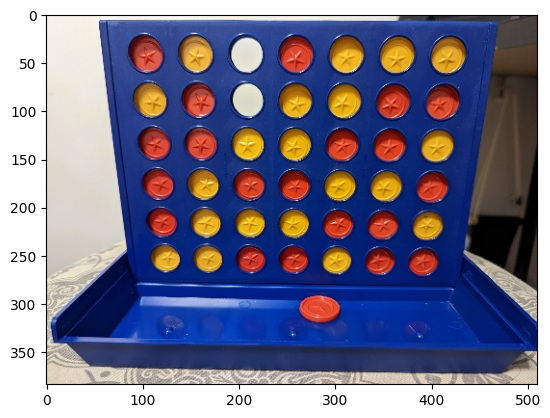

In [9]:
import cv2
from matplotlib import pyplot as plt
from PIL import Image

im = Image.open("datasets/c4/clean/c4_96.jpg")
plt.imshow(im)

In [10]:
import numpy as np
predictor = C4Predictor(model, min_size_test=384, max_size_test=510)
outputs = predictor(np.array(im))
# the output object categories and corresponding bounding boxes
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 2, 2, 1, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3,
        2, 2, 1, 3, 2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 0],
       device='cuda:0')
Boxes(tensor([[329.6438,  19.2433, 386.3789, 273.8582],
        [374.2791,  20.1561, 439.8856, 274.1294],
        [ 88.5407,  69.0583, 127.8098, 110.1558],
        [289.4915,  69.4149, 329.1310, 110.4245],
        [335.4179, 160.8869, 372.3814, 196.4647],
        [284.5969,  18.3318, 332.3608, 271.5788],
        [287.3499, 160.3371, 324.1215, 195.8048],
        [ 80.3421,  16.6054, 143.0765, 270.9843],
        [378.6536, 202.5103, 414.5235, 236.7308],
        [133.5161,  16.7040, 186.0533, 271.0381],
        [ 92.0718, 114.8587, 131.9269, 153.6402],
        [392.6825,  71.4741, 432.4629, 111.0814],
        [238.2930,  18.6901, 280.3463, 272.6787],
        [100.7980, 199.8185, 137.7568, 232.8716],
        [ 82.9349,  19.6559, 123.8288,  63.1657],
        [190.4063, 114.9357, 228.4013, 154.2405],
        [

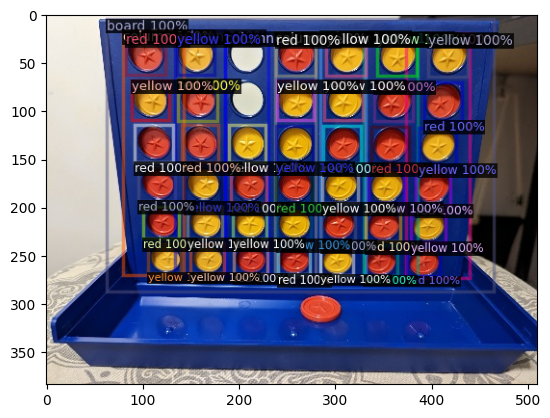

In [11]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

v = Visualizer(im, MetadataCatalog.get("c4_train"))
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image())

Setup wrapper for mobile model exporting

In [12]:
import contextlib
import copy
import os
import unittest
from PIL import Image

import torch
from d2go.export.exporter import convert_and_export_predictor
#from d2go.export.d2_meta_arch import patch_d2_meta_arch
from d2go.runner import create_runner, GeneralizedRCNNRunner
from d2go.model_zoo import model_zoo

from mobile_cv.common.misc.file_utils import make_temp_directory
from d2go.utils.testing.data_loader_helper import LocalImageGenerator, register_toy_coco_dataset
from torch.utils.mobile_optimizer import optimize_for_mobile

#patch_d2_meta_arch()


@contextlib.contextmanager
def create_fake_detection_data_loader(height, width, is_train):
    with make_temp_directory("detectron2go_tmp_dataset") as dataset_dir:
        cfg, runner = prepare_for_launch()
        #model = runner.build_model(cfg)
        cfg.DATASETS.TRAIN = ["c4_train"]
        cfg.DATASETS.TEST = ["c4_val"]

        if is_train:
            with register_toy_coco_dataset(
                "c4_train_fake", num_images=3
            ):
                train_loader = runner.build_detection_train_loader(cfg)
                yield train_loader
        else:
            with register_toy_coco_dataset(
                "c4_val_fake", num_images=3
            ):
                test_loader = runner.build_detection_test_loader(
                    cfg, dataset_name="c4_val"
                )
                yield test_loader

def test_export_torchvision_format(model):
    cfg_name = 'c4_faster_rcnn_fbnetv3a_C4.yaml'
    pytorch_model = model #model_zoo.get(cfg_name, trained=True)

    from typing import List, Dict
    class Wrapper(torch.nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model
            coco_idx_list = [1, 2, 3, 4, 5]

            self.coco_idx = torch.tensor(coco_idx_list)

        def forward(self, inputs: List[torch.Tensor]):
            x = inputs[0].unsqueeze(0) # * 255
            #scale = 1.0 #320.0 / min(x.shape[-2], x.shape[-1])
            #x = torch.nn.functional.interpolate(x, scale_factor=scale, mode="bilinear", align_corners=True, recompute_scale_factor=True)
            out = self.model(x[0])
            res : Dict[str, torch.Tensor] = {}
            res["boxes"] = out[0]
            res["labels"] = torch.index_select(self.coco_idx, 0, out[1])
            res["scores"] = out[2]
            return inputs, [res]

    #size_divisibility = max(pytorch_model.backbone.size_divisibility, 10)
    h, w = (384,510)#size_divisibility, size_divisibility * 2
    with create_fake_detection_data_loader(h, w, is_train=False) as data_loader:
        cfg, runner = prepare_for_launch()
        predictor_path = convert_and_export_predictor(
            cfg,
            copy.deepcopy(pytorch_model),
            "torchscript_mobile",#"torchscript_int8@tracing",
            './',
            data_loader,
        )

        orig_model = torch.jit.load(os.path.join(predictor_path, "model.jit"))
        wrapped_model = Wrapper(orig_model)
        # optionally do a forward
        wrapped_model([torch.rand(3, 384, 510)])
        scripted_model = torch.jit.script(wrapped_model)
        torch.jit.save(scripted_model, "d2go_scripted.pt")
        optimized_torchscript_model = optimize_for_mobile(scripted_model)
        optimized_torchscript_model._save_for_lite_interpreter("d2go_mobile_opt.ptl")
        #scripted_model.save("d2go_mobile.pt")

Load model parameters here if re-exporting

In [ ]:
#model.load_state_dict(torch.load("/home/tho121/C4Yolo/output_3/model_final.pth")["model"])

In [13]:
model.eval()
test_export_torchvision_format(model.cpu())

INFO:d2go.runner.default_runner:Building detection test loader for dataset: c4_val ...
INFO:d2go.runner.default_runner:Using dataset mapper:
D2GoDatasetMapper:
  is_train: False
  image_loader: None
  tfm_gens: 

INFO:detectron2.data.datasets.coco:Loaded 99 images in COCO format from datasets/c4/labels.json
INFO:detectron2.data.common:Serializing the dataset using: <class 'mobile_cv.torch.utils_pytorch.shareables.SharedList'>
INFO:mobile_cv.torch.utils_pytorch.shareables:Serializing 99 elements to byte tensors and concatenating them all ...
INFO:mobile_cv.torch.utils_pytorch.shareables:Serialized dataset takes 0.14 MiB
INFO:mobile_cv.torch.utils_pytorch.shareables:Moving serialized dataset to shared memory ...
INFO:mobile_cv.torch.utils_pytorch.shareables:Moving data to shared memory (SharedMemory('psm_de9a9261', size=145247)) ...
INFO:mobile_cv.torch.utils_pytorch.shareables:Moving data to shared memory (SharedMemory('psm_ff3eb87c', size=792)) ...
INFO:mobile_cv.torch.utils_pytorch.sh